# Imports

In [ ]:
import pandas as pd
import spacy
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Работа с датасетом

In [ ]:
#открываем датасет
data = pd.read_csv('/content/Захарова,_Нигамедзянова_АОЕЯ_проект_Захарова,_Нигамедзянова_АОЕЯ (2).csv')
data.head()

,Full context,1 level,2 level,conn,ton
0,"Девы, что лучше май-слинг или эрго?",1,8,neutral,neutral
1,"""http:// www. esky. ru/ catalog/ item/ 1739/ 2...",1,8,neutral,neutral
2,"""да девы, эстетика, да и не только она, еще от...",1,8,neutral,positive
3,"Неспроста же они дешевле чем камы и переги. "" ...",1,8,neutral,negative
4,"Девы, такая проблема-ре перестал ходить на гор...",1,8,neutral,negative


Датасет состоит из 5 колонок:

1.   **Full context**, содержит собственно контекст с номинацией лица;
2.   **1 level** - номер группы;
3.   **2 level** - номер подгруппы;
4.   **conn** - коннотация (позитивная, негативная или нейтральная). Позже, при обучении модели мы перекодируем этот столбец;
5.   **ton** - тональность текста (позитивная, негативная или нейтральная). Этот столбец при обучении мы тоже перекодируем.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Full context  1647 non-null   object
 1   1 level       1647 non-null   int64 
 2   2 level       1647 non-null   int64 
 3   conn          1647 non-null   object
 4   ton           1647 non-null   object
dtypes: int64(2), object(3)
memory usage: 64.5+ KB


Можно увидеть, что колонки 1 level, 2 level представлены целыми числами, а все остальные - текстовыми данными.

## Предобработка датасета

In [ ]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 42.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("ru_core_news_sm")

In [ ]:
def preprocess(text):
    # Удаление ссылок
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Удаление слэшей
    text = re.sub(r'\/', ' ', text)
    # Удаление цифр
    text = re.sub(r'\d+', '', text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(tokens)

In [ ]:
result_df = data.copy()
#применяем предобработку ко всему датасету
result_df['Full context'] = result_df['Full context'].apply(lambda x: pd.Series(preprocess(x)))

In [ ]:
result_df

,Full context,1 level,2 level,conn,ton
0,"дева , хороший май - слинг эрго ?",1,8,neutral,neutral
1,""" esky . ru catalog item дева , ск...",1,8,neutral,neutral
2,""" дева , эстетик , , партия , цвет хз зависеть...",1,8,neutral,positive
3,"неспроста дешёвый камы переги . "" дева ! итог ...",1,8,neutral,negative
4,"дева , проблема - ре перестать ходить горшок !...",1,8,neutral,negative
...,...,...,...,...,...
1642,упражнение артист балет день девочка мальчик .,2,9,neutral,neutral
1643,"уютный тёплый пространство "" lucky""@ luckyvrn ...",2,9,neutral,neutral
1644,"три стадии развитие мальчиков мальчик расти , ...",2,9,neutral,neutral
1645,", утруждать , впихивать чадо полезный злак , о...",3,13,neutral,positive


In [ ]:
result_df = result_df.sample(frac=1).reset_index(drop=True)
result_df

# перемешиваем датафрейм

,Full context,1 level,2 level,conn,ton
0,― упасть pешкой пиво ! ― встанет pебpом баба...,1,8,neutral,neutral
1,"понимание баба , мужик , виноватый , ипет !",1,8,negative,negative
2,садиться здоровый лысый мужик .,4,4,neutral,negative
3,мальчик опустить глаз тихо сказать : – собака .,2,9,neutral,neutral
4,"спрашивать ― отвечать : , баба маша поддрержив...",2,11,neutral,neutral
...,...,...,...,...,...
1642,мужик забирать,1,8,neutral,negative
1643,"мальчик португалия , , видео перевести английс...",2,9,neutral,neutral
1644,"спасибо , туфелька треугольничке : "" дурной ба...",1,8,negative,neutral
1645,нa грузинский свaдьбе другому : ― нa многих св...,1,8,neutral,negative


## Создание датасетов первого уровня


Здесь мы выделяем датасет для обучения модели, которая должна предсказать суперкласс лексемы, т.е. целевая переменная: колонка '1 level'.

In [ ]:
#выделение целевой переменной
X_top = result_df.drop(['1 level', '2 level'], axis = 1)
y_top = result_df['1 level']

In [ ]:
# делим данные
X_top_train, X_top_test, y_top_train, y_top_test = train_test_split(X_top, y_top,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=result_df['1 level'])

## Создание датасетов второго уровня

Выделяем отдельный датасет для каждой супергруппы, чтобы в дальнейшем обучить на каждом из них модель

### Первая группа

In [ ]:
#отделяем группу с первым значением
df_const = result_df[result_df['1 level'] == 1]
df_const

,Full context,1 level,2 level,conn,ton
0,― упасть pешкой пиво ! ― встанет pебpом баба...,1,8,neutral,neutral
1,"понимание баба , мужик , виноватый , ипет !",1,8,negative,negative
5,"думать ёж мужик фортуну хвост схватить , специ...",1,8,neutral,positive
13,"собственный ощущение мужик делать креститься ,...",1,8,negative,negative
14,"( принцип , пользоваться общественный транспор...",1,8,negative,negative
...,...,...,...,...,...
1639,""" королём шут "" ровно история — детский страши...",1,8,neutral,negative
1642,мужик забирать,1,8,neutral,negative
1644,"спасибо , туфелька треугольничке : "" дурной ба...",1,8,negative,neutral
1645,нa грузинский свaдьбе другому : ― нa многих св...,1,8,neutral,negative


In [ ]:
#выделяем целевую переменную
X_const = df_const.drop(['1 level', '2 level'], axis = 1)
y_const = df_const['2 level']

In [ ]:
#выделяем обучающую и тестовую выборку
X_const_train, X_const_test, y_const_train, y_const_test = train_test_split(X_const, y_const,
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=df_const['2 level'])

### Вторая группа

In [ ]:
#отделяем группу со вторым значением
df_age = result_df[result_df['1 level'] == 2]
df_age

,Full context,1 level,2 level,conn,ton
3,мальчик опустить глаз тихо сказать : – собака .,2,9,neutral,neutral
4,"спрашивать ― отвечать : , баба маша поддрержив...",2,11,neutral,neutral
6,мальчик пересекать проезжий часть регулируемый...,2,9,neutral,negative
7,семья путешествие гранд - каньон останавливать...,2,9,neutral,neutral
8,село знать . убить баба машу ? ?,2,11,neutral,neutral
...,...,...,...,...,...
1637,"вечер телек , словно прокиснуть бабка , сидеть...",2,11,negative,negative
1638,"год - девочка стайками влюбляться мальчик , оп...",2,9,neutral,neutral
1640,… место бабка дарья начинать плакать .,2,11,neutral,neutral
1641,"обратиться специалист , забыть взять , результ...",2,9,neutral,neutral


In [ ]:
#отделяем  целевую переменную
X_age = df_age.drop(['1 level', '2 level'], axis = 1)
y_age = df_age['2 level']

In [ ]:
#выделяем обучающую и тестовую выборку
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X_age, y_age,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_age['2 level'])

### Третья группа

In [ ]:
#отделяем группу с третьим значением
df_env = result_df[result_df['1 level'] == 3]
df_env

,Full context,1 level,2 level,conn,ton
11,"спрашивать , - устраивать понимать определятьс...",3,12,neutral,neutral
27,", сослаться плохой родительский воспитание , б...",3,13,neutral,neutral
54,"говорить , сторона белый пушистый . …… . челов...",3,13,neutral,neutral
113,"знать , сыграть какой - роль дело проект , мол...",3,12,neutral,neutral
128,заявлять : ― - предок ― папка мамка бабка дедк...,3,13,neutral,neutral
...,...,...,...,...,...
1573,бабка ― детство раз …,3,13,neutral,neutral
1578,"внешний данными бабу найти , добиваться прийти...",3,12,neutral,neutral
1611,"любить евреев- ; жид , бабка сторона мать .",3,13,neutral,neutral
1618,"рада , день провести близкими , первый половин...",3,12,positive,positive


In [ ]:
#сюда попало единичное значение, его нужно убрать
df_env['2 level'].value_counts()

2 level
12    75
13    49
11     1
Name: count, dtype: int64

In [ ]:
#посмотрим индекс единичного значения
df_env[df_env['2 level'] == 11].index

Index([522], dtype='int64')

In [ ]:
#удалим единичное значение, чтобы не было ошибки при делении на выборки
df_env.drop(df_env[df_env['2 level'] == 11].index, axis=0, inplace = True)
df_env['2 level'].value_counts()

<ipython-input-56-e9b048203488>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_env.drop(df_env[df_env['2 level'] == 11].index, axis=0, inplace = True)


2 level
12    75
13    49
Name: count, dtype: int64

In [ ]:
#выделяем целевую переменную
X_env = df_env.drop(['1 level', '2 level'], axis = 1)
y_env = df_env['2 level']

In [ ]:
#выделяем обучающую и тестовую выборку
X_env_train, X_env_test, y_env_train, y_env_test = train_test_split(X_env, y_env,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_env['2 level'])

# Векторизация

In [ ]:
def create_X(X_train, X_test, mode='meaning'):
    """
    Vectorize texts and combine with additional features.
    """
    # Создание TF-IDF векторизатора для преобразования текстов в векторы
    vectorizer = TfidfVectorizer()

    # Объединение текстов из нескольких колонок
    if  mode == 'meaning':
      X_train_combined = X_train['Full context'] + " " + X_train['conn'] + " " + X_train['ton'].astype(str)
      X_test_combined = X_test['Full context'] + " " + X_test['conn'] + " " + X_test['ton'].astype(str)
    elif mode == 'conn' or mode == 'ton':
      X_train_combined = X_train['Full context']
      X_test_combined = X_test['Full context']

    # Преобразование текстов в обучающем наборе данных в TF-IDF векторы
    vectorised_train = vectorizer.fit_transform(X_train_combined)
    # Преобразование текстов в тестовом наборе данных в TF-IDF векторы
    vectorised_test = vectorizer.transform(X_test_combined)

    # Преобразование разреженных матриц в DataFrame для удобства объединения
    X_train_vectors = pd.DataFrame(vectorised_train.toarray(), columns=vectorizer.get_feature_names_out())
    X_test_vectors = pd.DataFrame(vectorised_test.toarray(), columns=vectorizer.get_feature_names_out())

    if mode == 'conn' or mode == 'ton':
      # Извлечение дополнительных признаков из обучающего набора данных
      train_features = X_train.drop(['Full context'], axis=1)
      # Извлечение дополнительных признаков из тестового набора данных
      test_features = X_test.drop(['Full context'], axis=1)
      # Объединение TF-IDF векторов и дополнительных признаков для обучающего набора данных
      X_train_result = pd.concat([X_train_vectors, train_features.reset_index(drop=True)], axis=1)
      # Объединение TF-IDF векторов и дополнительных признаков для тестового набора данных
      X_test_result = pd.concat([X_test_vectors, test_features.reset_index(drop=True)], axis=1)
      return X_train_result.values, X_test_result.values, vectorizer

    # Возвращение результирующих данных как numpy массивов
    return X_train_vectors.values, X_test_vectors.values, vectorizer

In [ ]:
vectorised_top_train, vectorised_top_test, vectorizer_top = create_X(X_top_train, X_top_test)

In [ ]:
vectorised_const_train, vectorised_const_test, vectorizer_const = create_X(X_const_train, X_const_test)

In [ ]:
vectorised_age_train, vectorised_age_test, vectorizer_age = create_X(X_age_train, X_age_test)

In [ ]:
vectorised_env_train, vectorised_env_test, vectorizer_env = create_X(X_env_train, X_env_test)

# Обучение модели верхнего уровня

In [ ]:
vectorised_top_train.shape

(1317, 6658)

In [ ]:
# Обучение модели верхнего уровня
svm_top = SVC(kernel='linear')
svm_top.fit(vectorised_top_train, y_top_train)

# Прогнозирование на тестовых данных
y_pred = svm_top.predict(vectorised_top_test)

Accuracy: 0.796969696969697


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.78      0.84      0.81       122
           2       0.81      0.93      0.87       169
           3       0.50      0.04      0.07        25
           4       1.00      0.11      0.20         9
           5       0.00      0.00      0.00         5

    accuracy                           0.80       330
   macro avg       0.62      0.39      0.39       330
weighted avg       0.77      0.80      0.76       330



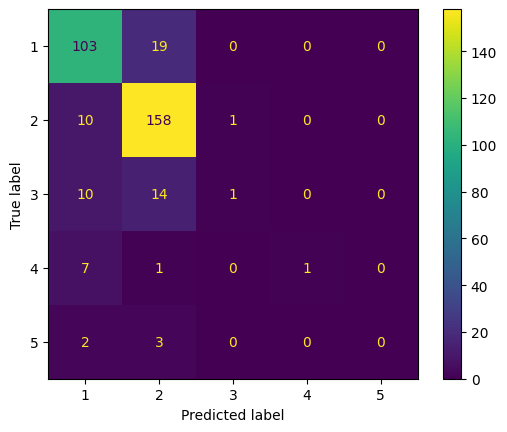

In [ ]:
# Оценка точности модели
accuracy = accuracy_score(y_top_test, y_pred)
print(f'Accuracy: {accuracy}')
ConfusionMatrixDisplay.from_estimator(svm_top, vectorised_top_test, y_top_test)

print(classification_report(y_top_test, y_pred))

Для более точной интерпретации метрик посмотрим на количество разных классов в выборке

In [ ]:
result_df['1 level'].value_counts()

1 level
2    845
1    607
3    125
4     44
5     26
Name: count, dtype: int64

Можно заметить,что между количеством элемментов в классах есть дисбаланс. В таком случае полагаться на acccuracy нельзя, хотя она получилась довольно высокой - 0.8. Лучше посмотреть на остальные метрики:  recall, precision и f1. Для первых 2 классов (просто констатация и называние по возрасту) они получились довольно высокими: 0.74 и больше, так как в первых 2 классах объектов больше всего. В оставшихся трех группах экземпляров значительно меньше, из-за чего и значения метрик ниже.

# Обучение моделей нижнего уровня

Здесь мы будем обучать модель предсказывать подгруппы. Для каждой из групп создается отдельная модель, которая обучается на всех значениях, входящих в данную группу.

## Первая группа

In [ ]:
#обучение модели для первого значения
svm_const = SVC(kernel='linear')
svm_const.fit(vectorised_const_train, y_const_train)

# Прогнозирование на тестовых данных
y_pred_const = svm_const.predict(vectorised_const_test)

Accuracy: 0.9508196721311475
              precision    recall  f1-score   support

           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       0.95      1.00      0.97       116

    accuracy                           0.95       122
   macro avg       0.32      0.33      0.32       122
weighted avg       0.90      0.95      0.93       122



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


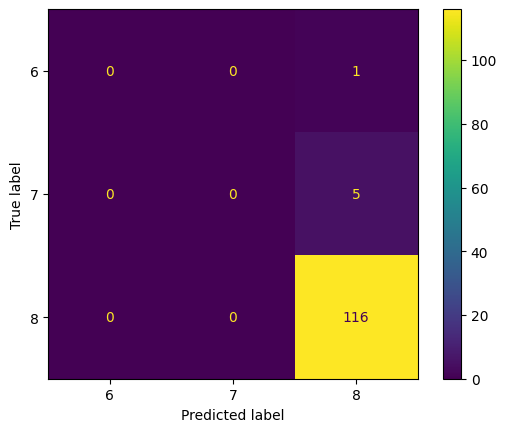

In [ ]:
# Оценка точности модели
accuracy = accuracy_score(y_const_test, y_pred_const)
print(f'Accuracy: {accuracy}')
ConfusionMatrixDisplay.from_estimator(svm_const, vectorised_const_test, y_const_test)

print(classification_report(y_const_test, y_pred_const))

In [ ]:
df_const['2 level'].value_counts()

2 level
8    575
7     26
6      6
Name: count, dtype: int64

Здесь тоже наблюдается дисбаланс классов: больше всего их в подгруппе 8 (называние человека по полу/просто незнакомый человек), поэтому, опять же, высокому значению accuracy тоже верить нельзя. Метрики для 8 подгруппы очень высокие, однако для оставшихся 2 подгрупп значения всех метрик равны нулю из-за очень маленького количества экземпляров в классах.

## Вторая группа

In [ ]:
#обучение модели для второго значения
svm_age = SVC(kernel='linear')
svm_age.fit(vectorised_age_train, y_age_train)

# Прогнозирование на тестовых данных
y_pred_age = svm_age.predict(vectorised_age_test)

Accuracy: 0.9763313609467456


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           9       0.98      1.00      0.99       104
          10       0.00      0.00      0.00         3
          11       0.97      0.98      0.98        62

    accuracy                           0.98       169
   macro avg       0.65      0.66      0.66       169
weighted avg       0.96      0.98      0.97       169



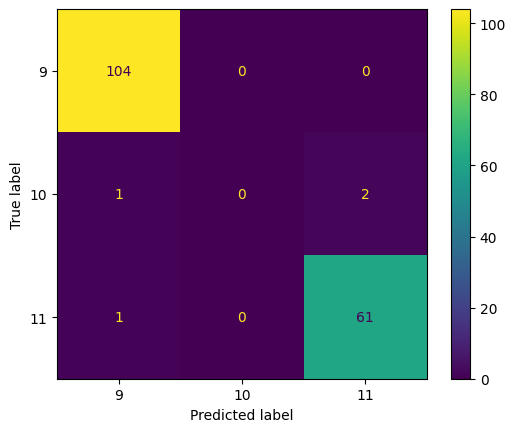

In [ ]:
# Оценка точности модели
accuracy = accuracy_score(y_age_test, y_pred_age)
print(f'Accuracy: {accuracy}')
ConfusionMatrixDisplay.from_estimator(svm_age, vectorised_age_test, y_age_test)

print(classification_report(y_age_test, y_pred_age))

In [ ]:
df_age['2 level'].value_counts()

2 level
9     521
11    309
10     15
Name: count, dtype: int64

Опять же, виден большой дисбаланс между группами и хорошее значение accuracy. Здесь для 9 и 11 классов, где больше всего экземпляров, метрики очень высокие и даже достигают 1. Так как экземпляров 10 класса очень мало, метрики для него равны нулю: модели  не хватило данных для обучения.

## Третья группа

In [ ]:
#обучение модели для третьего значения
svm_env = SVC(kernel='linear')
svm_env.fit(vectorised_env_train, y_env_train)

# Прогнозирование на тестовых данных
y_pred_env = svm_env.predict(vectorised_env_test)

Accuracy: 0.92
              precision    recall  f1-score   support

          12       0.88      1.00      0.94        15
          13       1.00      0.80      0.89        10

    accuracy                           0.92        25
   macro avg       0.94      0.90      0.91        25
weighted avg       0.93      0.92      0.92        25



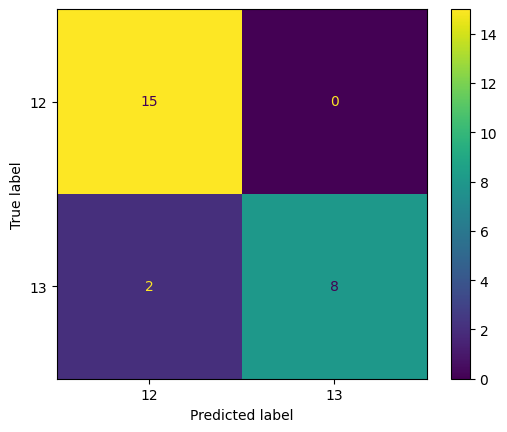

In [ ]:
# Оценка точности модели
accuracy = accuracy_score(y_env_test, y_pred_env)
print(f'Accuracy: {accuracy}')
ConfusionMatrixDisplay.from_estimator(svm_env, vectorised_env_test, y_env_test)

print(classification_report(y_env_test, y_pred_env))

In [ ]:
df_env['2 level'].value_counts()

2 level
12    75
13    49
Name: count, dtype: int64

В классах 3 группы экземпляров в целом очень мало, поэтому качество обучения может быть не очень высоким. Однако значения  метрик здесь тоже тоже большие для обоих классов и снова могут даже достигать единицы.

# Обучение на всех данных

In [ ]:
X_all = result_df.drop(['1 level', '2 level'], axis = 1)
y_all = result_df['2 level']

In [ ]:
#разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=result_df['2 level'])

In [ ]:
#векторизация
vectorised_train, vectorised_test, vectorizer = create_X(X_train, X_test)

In [ ]:
#обучение модели для всего датасета
svm = SVC(kernel='linear')
svm.fit(vectorised_train, y_train)

# Прогнозирование на тестовых данных
y_pred_all= svm.predict(vectorised_test)

Accuracy: 0.7909090909090909


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           4       1.00      0.11      0.20         9
           5       1.00      0.20      0.33         5
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         5
           8       0.72      0.91      0.81       115
           9       0.85      0.97      0.91       105
          10       0.00      0.00      0.00         3
          11       0.83      0.84      0.83        62
          12       0.00      0.00      0.00        15
          13       0.00      0.00      0.00        10

    accuracy                           0.79       330
   macro avg       0.44      0.30      0.31       330
weighted avg       0.72      0.79      0.74       330



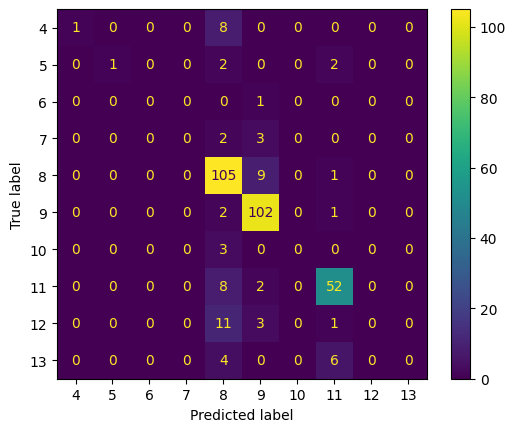

In [ ]:
# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred_all)
print(f'Accuracy: {accuracy}')
ConfusionMatrixDisplay.from_estimator(svm, vectorised_test, y_test)

print(classification_report(y_test, y_pred_all))

In [ ]:
result_df['2 level'].value_counts()

2 level
8     575
9     521
11    310
12     75
13     49
4      44
7      26
5      26
10     15
6       6
Name: count, dtype: int64

Самые многочисленные классы: 8 (называние человека по полу), 9(люди молодого возраста) и 11 (люди пожилого возраста). Для этих подгрупп значения  метрик высокие: 0.73 и больше. Однако для остальных классов, из-за  небольшого количества данных для обучения, метрики либо очень низкие (0.2, 0.3 и меньше), либо вовсе равны нулю.

## Подбор гиперпараметров

In [ ]:
# Определение сетки гиперпараметров
param_grid = {
    'C': [0.1, 1, 10, 100],  # Параметр регуляризации
    'kernel': ['linear', 'rbf', 'poly'],  # Ядро
    'gamma': ['scale', 'auto'],  # Параметр ядра
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

# Поиск лучших гиперпараметров
grid_search.fit(vectorised_train, y_train)

# Лучшие гиперпараметры
best_params = grid_search.best_params_
print("Лучшие гиперпараметры:", best_params)

Лучшие гиперпараметры: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


TypeError: SVC.__init__() takes 1 positional argument but 4 were given

In [ ]:
# Обучение модели с лучшими гиперпараметрами
best_svm = SVC(C=10, gamma='scale', kernel='linear')
best_svm.fit(vectorised_train, y_train)

# Прогнозирование на тестовых данных
y_pred_best = best_svm.predict(vectorised_test)

Точность на тестовых данных: 0.8151515151515152


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           4       0.75      0.33      0.46         9
           5       1.00      0.20      0.33         5
           6       0.00      0.00      0.00         1
           7       0.50      0.20      0.29         5
           8       0.76      0.92      0.83       115
           9       0.89      0.97      0.93       105
          10       0.00      0.00      0.00         3
          11       0.83      0.87      0.85        62
          12       0.50      0.07      0.12        15
          13       1.00      0.10      0.18        10

    accuracy                           0.82       330
   macro avg       0.62      0.37      0.40       330
weighted avg       0.80      0.82      0.78       330



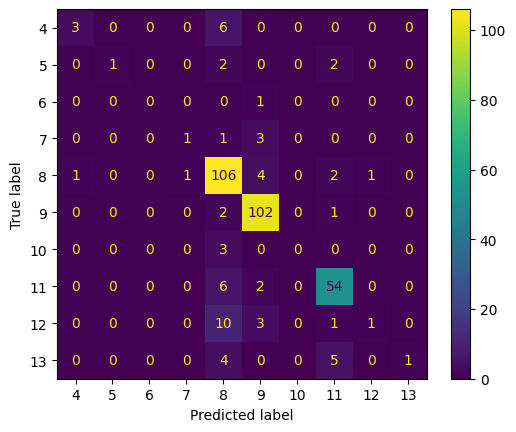

In [ ]:
# Оценка луччшей модели
accuracy = accuracy_score(y_test, y_pred_best)
print("Точность на тестовых данных:", accuracy)

ConfusionMatrixDisplay.from_estimator(best_svm, vectorised_test, y_test)

print(classification_report(y_test, y_pred_best))

Подбор гиперпараметров немного повысил accuracy, но эта метрика для нас не является самой важной. Гораздо важнее то, что поднялись значения метрик для немногочисленных классов. Например, без гиперпараметров для классов 4, 7 и 12 метрики были нулевыми. Подбор гиперпараметров поднял значения для многих классов, кроме 6 и 10, которые имеют наименьшее количество экземпляров.

# Предсказание коннотации

Здесь мы попробуем предсказать коннотацию лексем. Вначале мы перекодируем значения в столбцах с тональностью и коннотацией в числовой вид, затем выделим целевую переменную, разделим данные на обучающую и тестовую выборку, векторизуем данные и обучим модель.

In [ ]:
#кодировка столбца
#кодируем и тональность, и коннотацию
names = {'conn': {'negative': 0, 'neutral': 1, 'positive': 2},
         'ton': {'negative': 0, 'neutral': 1, 'positive': 2}}
coded_result = result_df.replace(names)

In [ ]:
coded_result

,Full context,1 level,2 level,conn,ton
0,― упасть pешкой пиво ! ― встанет pебpом баба...,1,8,1,1
1,"понимание баба , мужик , виноватый , ипет !",1,8,0,0
2,садиться здоровый лысый мужик .,4,4,1,0
3,мальчик опустить глаз тихо сказать : – собака .,2,9,1,1
4,"спрашивать ― отвечать : , баба маша поддрержив...",2,11,1,1
...,...,...,...,...,...
1642,мужик забирать,1,8,1,0
1643,"мальчик португалия , , видео перевести английс...",2,9,1,1
1644,"спасибо , туфелька треугольничке : "" дурной ба...",1,8,0,1
1645,нa грузинский свaдьбе другому : ― нa многих св...,1,8,1,0


По датафрейму можно заметить, что данные в последних 2 столбцах перекодировались в числовой формат.

In [ ]:
coded_result.corr(numeric_only=True)

,1 level,2 level,conn,ton
1 level,1.000000,0.143676,0.138148,0.044294
2 level,0.143676,1.000000,-0.150357,0.036258
conn,0.138148,-0.150357,1.000000,0.313497
ton,0.044294,0.036258,0.313497,1.000000


In [ ]:
X_conn = coded_result.drop(['conn'], axis = 1)
y_conn = coded_result['conn']

In [ ]:
#разделение на выборки
X_train_conn, X_test_conn, y_train_conn, y_test_conn = train_test_split(X_conn, y_conn,
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=result_df['conn'])

In [ ]:
#векторизация
vectorised_conn_train, vectorised_conn_test, vectorizer_conn = create_X(X_train_conn, X_test_conn, mode='conn')

In [ ]:
#обучение модели для коннотации
svm_conn = SVC(kernel='linear')
svm_conn.fit(vectorised_conn_train, y_train_conn)

# Прогнозирование на тестовых данных
y_pred_conn= svm_conn.predict(vectorised_conn_test)

Accuracy: 0.8363636363636363
              precision    recall  f1-score   support

           0       0.75      0.08      0.15        37
           1       0.84      1.00      0.91       267
           2       0.78      0.27      0.40        26

    accuracy                           0.84       330
   macro avg       0.79      0.45      0.49       330
weighted avg       0.82      0.84      0.78       330



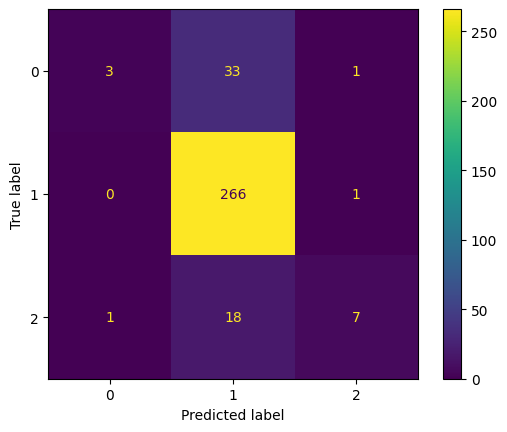

In [ ]:
# Оценка точности модели
accuracy = accuracy_score(y_test_conn, y_pred_conn)
print(f'Accuracy: {accuracy}')
ConfusionMatrixDisplay.from_estimator(svm_conn, vectorised_conn_test, y_test_conn)

print(classification_report(y_test_conn, y_pred_conn))

In [ ]:
coded_result['conn'].value_counts()

conn
1    1333
0     185
2     129
Name: count, dtype: int64

Лексемы, имеющие нейтральную коннотацию, составляют 80% выборки, благодаря чему модель лучше всего определяет именно лексемы с нейтральной коннотацией (recall для первого класса = 0.99, precision для него же = 0.81). Также модель пыталась предсказывать отрицательную коннотацию, но получилось не очень удачно: precision для нулевого класса составляет всего 0.5, а recall и вовсе 0.03. Для позитивной коннотации ситуация еще хуже: все метрики равны нулю.

# Предсказание тональности

In [ ]:
X_ton = coded_result.drop(['ton'], axis = 1)
y_ton = coded_result['ton']

In [ ]:
#разделение на выборки
X_train_ton, X_test_ton, y_train_ton, y_test_ton = train_test_split(X_ton, y_ton,
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=result_df['ton'])

In [ ]:
#векторизация
vectorised_ton_train, vectorised_ton_test, vectorizer_ton = create_X(X_train_ton, X_test_ton, mode='ton')

In [ ]:
#обучение модели для тональности
svm_ton = SVC(kernel='linear')
svm_ton.fit(vectorised_ton_train, y_train_ton)

# Прогнозирование на тестовых данных
y_pred_ton= svm_ton.predict(vectorised_ton_test)

Accuracy: 0.7848484848484848
              precision    recall  f1-score   support

           0       0.55      0.48      0.51        60
           1       0.86      0.90      0.88       249
           2       0.38      0.29      0.32        21

    accuracy                           0.78       330
   macro avg       0.59      0.56      0.57       330
weighted avg       0.77      0.78      0.78       330



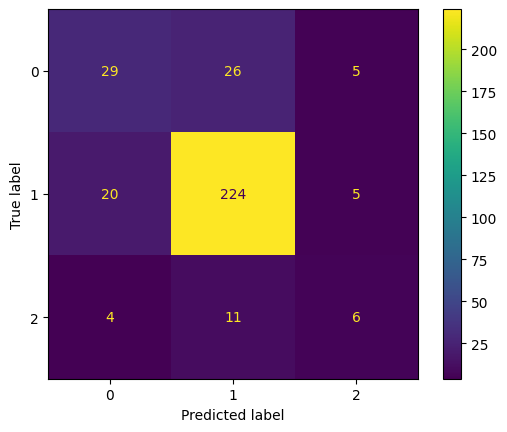

In [ ]:
# Оценка точности модели
accuracy = accuracy_score(y_test_ton, y_pred_ton)
print(f'Accuracy: {accuracy}')
ConfusionMatrixDisplay.from_estimator(svm_ton, vectorised_ton_test, y_test_ton)

print(classification_report(y_test_ton, y_pred_ton))

In [ ]:
coded_result['ton'].value_counts()

ton
1    1241
0     298
2     108
Name: count, dtype: int64

Как и в случае с коннотацией, на нейтральную тональность приходится подавляющее большинство примеров. Однако количество экземпляров с негативной тональностью чуть больше и метрики для них выше. Например, recall составляет уже 0.42, то есть модель справляется с предсказанием отрицательной тональности намного лучше, чем с отрицательной коннотацией. Для позитивной тональности ситуация снова печальная: метрики равны нулю.

# Тестирование работы алгоритма

1. Констатация (женщина, девушка, мужчина, обращения всех оттенков)
    6. оскорбление
    7. дружеское или ласковое обращение
    8. называние человека по полу/просто любой или незнакомый человек
2. Обозначение лица по возрасту
    9. Молодые лица
    10. Взрослые лица
    11. Пожилые лица
3. Окружение
    12. Подруги, знакомые, друзья, коллеги, любовник, сексуальный партнер, парень, жених, невеста
    13. Обозначение родственника\предка (в т.ч. жена муж)
4. Стереотипно маскулинный мужчина \ стереотипно женственная женщина
5. Род деятельности (проститутка, знахарка, гадалка)


In [ ]:
test1 = {'Full context': 'Привет, девы!', 'conn': 'neutral', 'ton': 'neutral'}
test2 = {'Full context': 'Эх ты, бабка, так вечно в старухах и будешь сидеть', 'conn': 'negative', 'ton': 'negative'}
test1_df = pd.DataFrame(test1, index=[0])
test2_df = pd.DataFrame(test2, index=[0])
print(test1_df)
print(test2_df)

    Full context     conn      ton
0  Привет, девы!  neutral  neutral
                                        Full context      conn       ton
0  Эх ты, бабка, так вечно в старухах и будешь си...  negative  negative


In [ ]:
test1_df['Full context'] = test1_df['Full context'].apply(lambda x: pd.Series(preprocess(x)))
test2_df['Full context'] = test2_df['Full context'].apply(lambda x: pd.Series(preprocess(x)))

In [ ]:
test1_df

,Full context,conn,ton
0,"привет , дева !",neutral,neutral


In [ ]:
def classify_text(text):
  # Векторизация текста для верхнего уровня
  X_text_combined = text['Full context'] + " " + text['conn'] + " " + text['ton']
  X_text_top = vectorizer_top.transform(X_text_combined)
  top_level_prediction = svm_top.predict(X_text_top.toarray())[0]

  # Дальнейшая классификация в зависимости от верхнего уровня
  if top_level_prediction == 1:
      X_text_combined = text['Full context'] + " " + text['conn'] + " " + text['ton']
      X_text_top = vectorizer_const.transform(X_text_combined)
      return svm_const.predict(X_text_top.toarray())[0]
  elif top_level_prediction == 2:
      X_text_combined = text['Full context'] + " " + text['conn'] + " " + text['ton']
      X_text_top = vectorizer_age.transform(X_text_combined)
      return svm_age.predict(X_text_top.toarray())[0]
  elif top_level_prediction == 3:
      X_text_combined = text['Full context'] + " " + text['conn'] + " " + text['ton']
      X_text_top = vectorizer_env.transform(X_text_combined)
      return svm_env.predict(X_text_top.toarray())[0]

  return top_level_prediction

# Пример использования
print(classify_text(test1_df))
print(classify_text(test2_df))


8
11
